# Inbound Tourist Prediction - CNN, RNN Model


 * CNN
 * RNN

## Overview

본 코드는 과거 30일의 데이터를 활용하여 미래 30일 입국자 수를 예측하는 인공지능 모델을 만드는 코드다. 


![daily_tourist_1](https://user-images.githubusercontent.com/59733867/106080650-d9905d80-615a-11eb-8f03-dc76ccceeb09.png)


위의 그림은 일별 전체 입국자 수를 나타내고 있다. 해당 그림에서 볼 수 있듯이, 계절성 패턴, 질병 요인, 정치이슈요인, 경제 요인 등이 일별 전체 입국자 수에 영향을 주고 있다.

--------------------------------------------------------------------------------------------------------------------------------------

본 코드는 미래 30일 입국자 수를 예측하기 위해 과거 30일 변수들을 입력 변수로 활용한 CNN, RNN 모델을 설계, 실험, 결과 도출하는 코드다. 입력 변수로는 미래 30일 입국자 수와 높은 상관관계를 가지는 변수로 판단되는 '과거 일별 입국자 수', '구글 트렌드 지수', '계절 요인', '질병 요인', '정치 이슈' 등을 사용한다.

데이터셋은 Training 세트와 Testing 세트로 분리하여 사용한다. Training set은 2010-01-01에서 2018-12-31까지의 데이터를 활용하고, 이 중 80%는 training에 나머지 20%는 validation으로 활용한다. 모델 훈련 후 테스팅 과정에 사용할 Testing set의 기간은 2019-01-01~2020-09-30로 코로나 기간을 포함하고 있다.

## Colab Setting

* 사용자의 구글 드라이브에 Inbound_Tourist_Prediction 디렉토리가 보관되어야 실행할 수 있습니다.

In [1]:
# Colab Setting
import os
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd '/content/gdrive/My Drive/Inbound_Tourist_Prediction'

/content/gdrive/My Drive/Inbound_Tourist_Prediction


## Import Libraries

In [3]:
# User-defined Data preprocessor
from utils.data_loader import DataLoader
from utils.spliter import WindowGenerator

# User-defined Visualization and Print Results
from utils.plot_util import plot
from utils.evaluation import printResult

# Model Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# Model Optimizer
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

# Dataframe
import pandas as pd
import numpy as np

# Model Structure
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPool1D, Input, Bidirectional, LSTM
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, InputLayer
from tensorflow.keras import backend as K

# Seed
from tensorflow.random import set_seed
from numpy.random import randint

## Input

입력변수로 활용할 데이터.

![screenshot_1](https://user-images.githubusercontent.com/59733867/106080760-0c3a5600-615b-11eb-8635-39fe6f11ac5f.PNG)


**Total_entry** : **일별 입국자 수의 시계열 패턴**을 학습하여 모델에 반영하기 위한 방법으로 30일 전의 입국자 수를 입력변수로 활용한다.

------------------------------------------------------------------------------------------------------------------------------------
**seoul hotel** : **한국과 한국 관광에 대한 관심도를 나타내는 지수**로 구글(Google)에서 제공하는 구글 트렌드 지수(Google Trend Index)를 활용한다. 구글 트렌드 지수는 설정한 기간 내 해당 키워드의 상대적 검색량을 0에서 100까지 지수화한 것이다. 'Seoul hotel'은 서울과 한국(서울) 관광에 대한 관심도를 보여주는 키워드로 일별 입국자 수와 높은 상관관계를 가진다.
![googletrend](https://user-images.githubusercontent.com/59733867/106080714-fa58b300-615a-11eb-8d95-b8cf3d63e345.PNG)

-------------------------------------------------------------------------------------------------------------------------------------
**disease** : 0,1로 나타내는 더미 변수로, 코로나, 메르스 등의 질병 팬데믹이 일어난 기간에는 1로 설정, 나머지는 0으로 설정한다.

**season** : {spring : 0, summer : 1, fall : 2, winter : 3}

**politics** : 0,1로 나타내는 더미 변수로, 중국의 한한령이 시행된 시기부터 1로 설정한다.(일본과의 정치 이슈는 제외)

In [4]:
data_loader = DataLoader()
Target = 'Total_entry'

features = [Target, 'seoul_hotel', 'disease', 'season', 'politics']

train, test, date_lists = data_loader.load_csv(path='./data/tourist_daily.csv', 
                                               features=np.concatenate((['Date'],features), axis=0), 
                                               split_date='2018-12-31')

## Model - CNN

### 시드 숫자 정하기

텐서플로우 모델 학습 시 무작위적으로 batch를 섞게 되는데, 이 때 섞는 규칙을 정하는 시드(seed) 숫자를 정합니다.

In [5]:
seedNum = 3394
set_seed(seedNum)
np.random.seed(seedNum)

### Preprocessing - input size : 30 days, output size : 30 days

![inputsize](https://user-images.githubusercontent.com/59733867/106080724-fcbb0d00-615a-11eb-9dc7-96101d7307e0.PNG)


본 모델은 30일 데이터를 활용하여 다음 30일 일별 입국자 수를 예측하는 모델이다. 30일의 데이터를 모델에 투입하기 위해, 입력변수 구조를 맞춰서 조정해야 한다. 


![inputsize_2](https://user-images.githubusercontent.com/59733867/106080731-fe84d080-615a-11eb-9448-011cd075a4eb.PNG)




In [6]:
CNN_input = (30, 30, 1)

wg_1 = WindowGenerator(train, input_width=CNN_input[0], label_width=CNN_input[1], shift=CNN_input[2])
twg_1 = WindowGenerator(test, input_width=CNN_input[0], label_width=CNN_input[1], shift=CNN_input[2])

train_cnn_x, train_cnn_y = wg_1.split_window()
test_cnn_x, test_cnn_y = twg_1.split_window()

In [7]:
model = Sequential()
model.add(Conv1D(64, 2, input_shape=(30,5)))
model.add(Activation('relu'))
model.add(MaxPool1D(pool_size = 2))

model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(30))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 29, 64)            704       
_________________________________________________________________
activation (Activation)      (None, 29, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 896)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               89700     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0

### Compile and Training

#### Hyper-parameters
모델에 포함되는 하이퍼 파라미터들을 조율할 수 있습니다.

* LOSS =  mean squared error
![image](https://www.datavedas.com/wp-content/uploads/2018/04/image003-1-300x105.png)

In [9]:
# 모델의 학습률입니다.
Lr = 0.001

# 옵티마이저 함수입니다.
Optimizer = Adam(learning_rate=Lr)

# 학습하는 최대 Epoch(iterations)입니다.
Epochs = 50

# Train 데이터 중 validation 데이터의 비율을 정합니다. 
Validation_split=0.2

# Batch size입니다.
Batch_size = 64

# 손실함수입니다.
Loss = 'mean_squared_error'

#callbacks
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)

#### Train
모델을 학습합니다.

In [10]:
model.compile(optimizer=Optimizer, loss=Loss)

history = model.fit(train_cnn_x,
                    train_cnn_y,
                    shuffle=True,
                    epochs=Epochs,
                    callbacks=[es, rlr],
                    validation_split=Validation_split,
                    verbose=1,
                    batch_size=Batch_size)

Epoch 1/50
41/41 [==============================] - 1s 17ms/step - loss: 676196886.0952 - val_loss: 59666132.0000
Epoch 2/50
41/41 [==============================] - 0s 6ms/step - loss: 166784002.2857 - val_loss: 58196392.0000
Epoch 3/50
41/41 [==============================] - 0s 6ms/step - loss: 121873633.7143 - val_loss: 47966492.0000
Epoch 4/50
41/41 [==============================] - 0s 7ms/step - loss: 104379576.9524 - val_loss: 39700548.0000
Epoch 5/50
41/41 [==============================] - 0s 6ms/step - loss: 96577729.1429 - val_loss: 45617616.0000
Epoch 6/50
41/41 [==============================] - 0s 6ms/step - loss: 86858188.7619 - val_loss: 44271456.0000
Epoch 7/50
41/41 [==============================] - 0s 6ms/step - loss: 82968223.2381 - val_loss: 38856956.0000
Epoch 8/50
41/41 [==============================] - 0s 7ms/step - loss: 81034455.2381 - val_loss: 39836940.0000
Epoch 9/50
41/41 [==============================] - 0s 9ms/step - loss: 78222558.0952 - val_loss: 4

#### Prediction
학습한 모델을 토대로 Train 데이터, Test 데이터를 활용하여 입국자 수를 예측합니다.

In [11]:
train_cnn_predict = model.predict(train_cnn_x)
test_cnn_predict = model.predict(test_cnn_x)

### Result
예측한 데이터와 실제 데이터를 토대로 나온 결과를 출력합니다.

* Monthly Absolute Percentage Error rate : 월 단위로 예측 후 월별 절대 오차율 평가

<center> $Monthly Error Rate = \lvert{\frac{True-Predict}{True}} \rvert$</center>

* Monthly Absolute Error  : 월 단위로 예측 후 실측치와의 절대 오차

<center> $Monthly Absolute Error = \lvert{True-Predict}\rvert$</center>

#### Plot
예측한 데이터와 실제 데이터를 그래프로 도시합니다.

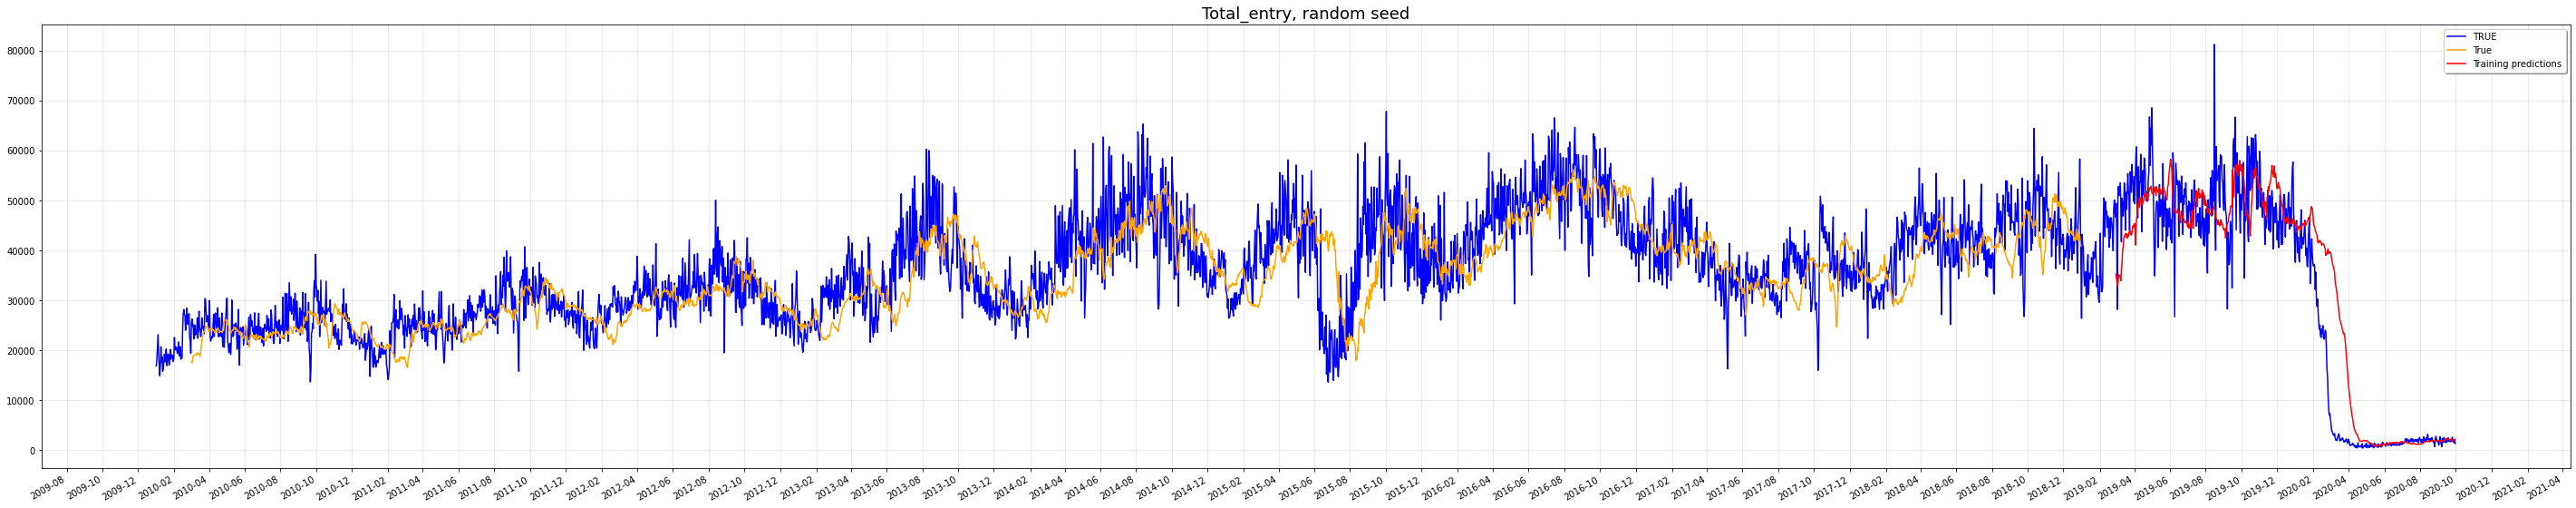

In [12]:
TRUE = pd.DataFrame(data_loader.original[:, 0:1], columns=["True"]).set_index(pd.Series(date_lists[0]))
prediction_train = wg_1.to_pandas(train_cnn_predict[1:][:,-1], date_lists[1], name="Train")
prediction_test = twg_1.to_pandas(test_cnn_predict[1:][:,-1], date_lists[2], name="Test")

plot(TRUE, prediction_train, prediction_test, show=True)

#### Evaluation
예측한 데이터와 실제 데이터의 차이, 월별 절대 오차율과 월별 절대 오차를 출력합니다.

In [13]:
printResult(date_lists[2], test_cnn_y, test_cnn_predict, Target, features)

[2019년 3월] | 실제 방문자 수: 1548193명    | 예상 방문자 수: 1243925명       | 차이: 304268명       | 절대 오차율: 19.65%
[2019년 4월] | 실제 방문자 수: 1640434명    | 예상 방문자 수: 1484723명       | 차이: 155711명       | 절대 오차율: 9.49%
[2019년 5월] | 실제 방문자 수: 1489072명    | 예상 방문자 수: 1613319명       | 차이: -124247명       | 절대 오차율: 8.34%
[2019년 6월] | 실제 방문자 수: 1481748명    | 예상 방문자 수: 1459369명       | 차이: 22379명       | 절대 오차율: 1.51%
[2019년 7월] | 실제 방문자 수: 1455545명    | 예상 방문자 수: 1512673명       | 차이: -57128명       | 절대 오차율: 3.92%
[2019년 8월] | 실제 방문자 수: 1602810명    | 예상 방문자 수: 1455878명       | 차이: 146932명       | 절대 오차율: 9.17%
[2019년 9월] | 실제 방문자 수: 1468157명    | 예상 방문자 수: 1524272명       | 차이: -56115명       | 절대 오차율: 3.82%
[2019년 10월] | 실제 방문자 수: 1658209명    | 예상 방문자 수: 1600161명       | 차이: 58048명       | 절대 오차율: 3.5%
[2019년 11월] | 실제 방문자 수: 1458691명    | 예상 방문자 수: 1570358명       | 차이: -111667명       | 절대 오차율: 7.66%
[2019년 12월] | 실제 방문자 수: 1458095명    | 예상 방문자 수: 1480045명       | 차이: -21950명       | 절대 오차율: 1.51%
[2020년 1월] | 실제 방

## Model - RNN

### Recurrent Neural Networks
In a recurrent neural network we store the output activations from one or more of the layers of the network. Often these are hidden later activations. Then, the next time we feed an input example to the network, we include the previously-stored outputs as additional inputs. You can think of the additional inputs as being concatenated to the end of the “normal” inputs to the previous layer. For example, if a hidden layer had 10 regular input nodes and 128 hidden nodes in the layer, then it would actually have 138 total inputs (assuming you are feeding the layer’s outputs into itself à la Elman) rather than into another layer). Of course, the very first time you try to compute the output of the network you’ll need to fill in those extra 128 inputs with 0s or something.

<img src="https://cdn-images-1.medium.com/max/1600/1*NKhwsOYNUT5xU7Pyf6Znhg.png">

Now, even though RNNs are quite powerful, they suffer from  **Vanishing gradient problem ** which hinders them from using long term information, like they are good for storing memory 3-4 instances of past iterations but larger number of instances don't provide good results so we don't just use regular RNNs. Instead, we use a better variation of RNNs: **Long Short Term Networks(LSTM).**

#### What is Vanishing Gradient problem?
Vanishing gradient problem is a difficulty found in training artificial neural networks with gradient-based learning methods and backpropagation. In such methods, each of the neural network's weights receives an update proportional to the partial derivative of the error function with respect to the current weight in each iteration of training. The problem is that in some cases, the gradient will be vanishingly small, effectively preventing the weight from changing its value. In the worst case, this may completely stop the neural network from further training. As one example of the problem cause, traditional activation functions such as the hyperbolic tangent function have gradients in the range (0, 1), and backpropagation computes gradients by the chain rule. This has the effect of multiplying n of these small numbers to compute gradients of the "front" layers in an n-layer network, meaning that the gradient (error signal) decreases exponentially with n while the front layers train very slowly.

<img src="https://cdn-images-1.medium.com/max/1460/1*FWy4STsp8k0M5Yd8LifG_Q.png">

### LSTM
An LSTM has a similar control flow as a recurrent neural network. It processes data passing on information as it propagates forward. The differences are the operations within the LSTM’s cells.  
![image](https://miro.medium.com/max/1917/1*0f8r3Vd-i4ueYND1CUrhMA.png)
These operations are used to allow the LSTM to keep or forget information. Now looking at these operations can get a little overwhelming so we’ll go over this step by step.  

#### Core Concept
The core concept of LSTM’s are the cell state, and it’s various gates. The cell state act as a transport highway that transfers relative information all the way down the sequence chain. You can think of it as the “memory” of the network. The cell state, in theory, can carry relevant information throughout the processing of the sequence. So even information from the earlier time steps can make it’s way to later time steps, reducing the effects of short-term memory. As the cell state goes on its journey, information get’s added or removed to the cell state via gates. The gates are different neural networks that decide which information is allowed on the cell state. The gates can learn what information is relevant to keep or forget during training.


#### Sigmoid
Gates contains sigmoid activations. A sigmoid activation is similar to the tanh activation. Instead of squishing values between -1 and 1, it squishes values between 0 and 1. That is helpful to update or forget data because any number getting multiplied by 0 is 0, causing values to disappears or be “forgotten.” Any number multiplied by 1 is the same value therefore that value stay’s the same or is “kept.” The network can learn which data is not important therefore can be forgotten or which data is important to keep.
![image](https://miro.medium.com/max/1282/1*rOFozAke2DX5BmsX2ubovw.gif)
Let’s dig a little deeper into what the various gates are doing, shall we? So we have three different gates that regulate information flow in an LSTM cell. A forget gate, input gate, and output gate.

#### Forget gate
First, we have the forget gate. This gate decides what information should be thrown away or kept. Information from the previous hidden state and information from the current input is passed through the sigmoid function. Values come out between 0 and 1. The closer to 0 means to forget, and the closer to 1 means to keep.
![image](https://miro.medium.com/max/1282/1*GjehOa513_BgpDDP6Vkw2Q.gif)

#### Input Gate
To update the cell state, we have the input gate. First, we pass the previous hidden state and current input into a sigmoid function. That decides which values will be updated by transforming the values to be between 0 and 1. 0 means not important, and 1 means important. You also pass the hidden state and current input into the tanh function to squish values between -1 and 1 to help regulate the network. Then you multiply the tanh output with the sigmoid output. The sigmoid output will decide which information is important to keep from the tanh output.
![image](https://miro.medium.com/max/1282/1*TTmYy7Sy8uUXxUXfzmoKbA.gif)

#### Cell State
Now we should have enough information to calculate the cell state. First, the cell state gets pointwise multiplied by the forget vector. This has a possibility of dropping values in the cell state if it gets multiplied by values near 0. Then we take the output from the input gate and do a pointwise addition which updates the cell state to new values that the neural network finds relevant. That gives us our new cell state.
![image](https://miro.medium.com/max/1282/1*S0rXIeO_VoUVOyrYHckUWg.gif)

#### Output Gate
Last we have the output gate. The output gate decides what the next hidden state should be. Remember that the hidden state contains information on previous inputs. The hidden state is also used for predictions. First, we pass the previous hidden state and the current input into a sigmoid function. Then we pass the newly modified cell state to the tanh function. We multiply the tanh output with the sigmoid output to decide what information the hidden state should carry. The output is the hidden state. The new cell state and the new hidden is then carried over to the next time step.
![image](https://miro.medium.com/max/1282/1*VOXRGhOShoWWks6ouoDN3Q.gif)

To review, the Forget gate decides what is relevant to keep from prior steps. The input gate decides what information is relevant to add from the current step. The output gate determines what the next hidden state should be.

-----------------------------------------------------------------------------------------------------------------------------------------

#### Bidirectional RNN

![bidirectional rnn](https://user-images.githubusercontent.com/59733867/106080613-c8475100-615a-11eb-9901-f5ed75ecae16.png)

Bidirectional recurrent neural networks(RNN) are putting two independent RNNs together. The input sequence is fed in normal time order for one network, and in reverse time order for another. This structure allows the networks to have both backward and forward information about the sequence at every time step. This approach has been used to great effect with Long Short-Term Memory (LSTM) Recurrent Neural Networks.

### 시드 숫자 정하기

텐서플로우 모델 학습 시 무작위적으로 batch를 섞게 되는데, 이 때 섞는 규칙을 정하는 시드(seed) 숫자를 정합니다.

In [14]:
seedNum = 2020
set_seed(seedNum)
np.random.seed(seedNum)

### Preprocessing - input size : 30 days, after 30 days, output size : 1 day

![inputsize_rnn](https://user-images.githubusercontent.com/59733867/106080753-093f6580-615b-11eb-9adb-c0c270c9033c.PNG)

본 모델은 30일 데이터를 활용하여 다음 30일 후 일별 입국자 수 하루를 예측하는 모델이다. 30일의 데이터를 모델에 투입하기 위해, 입력변수 구조를 맞춰서 조정해야 한다. 

In [15]:
RNN_input = (30, 1, 30)

#Normalization
RNN_train = data_loader.standardScale(train)
RNN_test = data_loader.standardScale(test)

wg_2 = WindowGenerator(RNN_train, input_width=RNN_input[0], label_width=RNN_input[1], shift=RNN_input[2])
twg_2 = WindowGenerator(RNN_test, input_width=RNN_input[0], label_width=RNN_input[1], shift=RNN_input[2])
train_rnn_x, train_rnn_y = wg_2.split_window()
test_rnn_x, test_rnn_y = twg_2.split_window()

In [16]:
units = [128,64]
num_of_stack = 2

def is_last_layer(stack_id, num_of_stack):
        if stack_id == num_of_stack-1:
            return True
        else:
            return False

model = Sequential()
model.add(InputLayer(input_shape=(30,5)))
for i in range(num_of_stack):
    if is_last_layer(units[i], num_of_stack):
        model.add(Bidirectional(LSTM(units=units, return_sequences=False)))
        model.add(Dropout(0.25))
        continue
    model.add(Bidirectional(LSTM(units=units[i], return_sequences=True, input_shape=(30,5))))

model.add(Dropout(0.25))
model.add(Dense(units=60, activation='tanh'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units=1, activation='linear'))

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 30, 256)           137216    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 30, 128)           164352    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 30, 60)            7740      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 60)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1800)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### Compile and Training

#### Hyper-parameters
모델에 포함되는 하이퍼 파라미터들을 조율할 수 있습니다.

* LOSS =  mean squared error
![image](https://www.datavedas.com/wp-content/uploads/2018/04/image003-1-300x105.png)

In [18]:
# 모델의 학습률입니다.
Lr = 0.001

# 옵티마이저 함수입니다.
Optimizer = Adam(learning_rate=Lr)

# 학습하는 최대 Epoch(iterations)입니다.
Epochs = 50

# Train 데이터 중 validation 데이터의 비율을 정합니다. 
Validation_split=0.2

# Batch size입니다.
Batch_size = 64

# 손실함수입니다.
Loss = 'mean_squared_error'

#callbacks
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)

#### Train
모델을 학습합니다.

In [19]:
model.compile(optimizer=Optimizer, loss=Loss)

history = model.fit(train_rnn_x,
                    train_rnn_y,
                    shuffle=True,
                    epochs=Epochs,
                    callbacks=[es, rlr],
                    validation_split=Validation_split,
                    verbose=1,
                    batch_size=Batch_size)

Epoch 1/50
41/41 [==============================] - 16s 242ms/step - loss: 0.3373 - val_loss: 0.3516
Epoch 2/50
41/41 [==============================] - 8s 202ms/step - loss: 0.2265 - val_loss: 0.3899
Epoch 3/50
41/41 [==============================] - 8s 200ms/step - loss: 0.2295 - val_loss: 0.3209
Epoch 4/50
41/41 [==============================] - 8s 198ms/step - loss: 0.2164 - val_loss: 0.4265
Epoch 5/50
41/41 [==============================] - 8s 199ms/step - loss: 0.2063 - val_loss: 0.3566
Epoch 6/50
41/41 [==============================] - 8s 202ms/step - loss: 0.2096 - val_loss: 0.3483
Epoch 7/50
41/41 [==============================] - 8s 203ms/step - loss: 0.1969 - val_loss: 0.3065
Epoch 8/50
41/41 [==============================] - 8s 199ms/step - loss: 0.2065 - val_loss: 0.3893
Epoch 9/50
41/41 [==============================] - 8s 200ms/step - loss: 0.1978 - val_loss: 0.4014
Epoch 10/50
41/41 [==============================] - 8s 199ms/step - loss: 0.1913 - val_loss: 0.426

#### Prediction
학습한 모델을 토대로 Train 데이터, Test 데이터를 활용하여 입국자 수를 예측합니다.

In [20]:
train_predict = model.predict(train_rnn_x)
test_predict = model.predict(test_rnn_x)

#Denormalization
inv_train_predict = data_loader.inverseScale(train_predict)
inv_test_predict = data_loader.inverseScale(test_predict)
original = data_loader.inverseScale(test_rnn_y)

### Result
예측한 데이터와 실제 데이터를 토대로 나온 결과를 출력합니다.

* Monthly Absolute Percentage Error rate : 월 단위로 예측 후 월별 오차율 평가

<center> $Monthly Error Rate = \lvert{\frac{True-Predict}{True}} \rvert$</center>

* Monthly Absolute Error : 월 단위로 예측 후 실측치와의 절대 오차

<center> $Monthly Absolute Error = \lvert{True-Predict}\rvert$</center>

#### Plot
예측한 데이터와 실제 데이터를 그래프로 도시합니다.

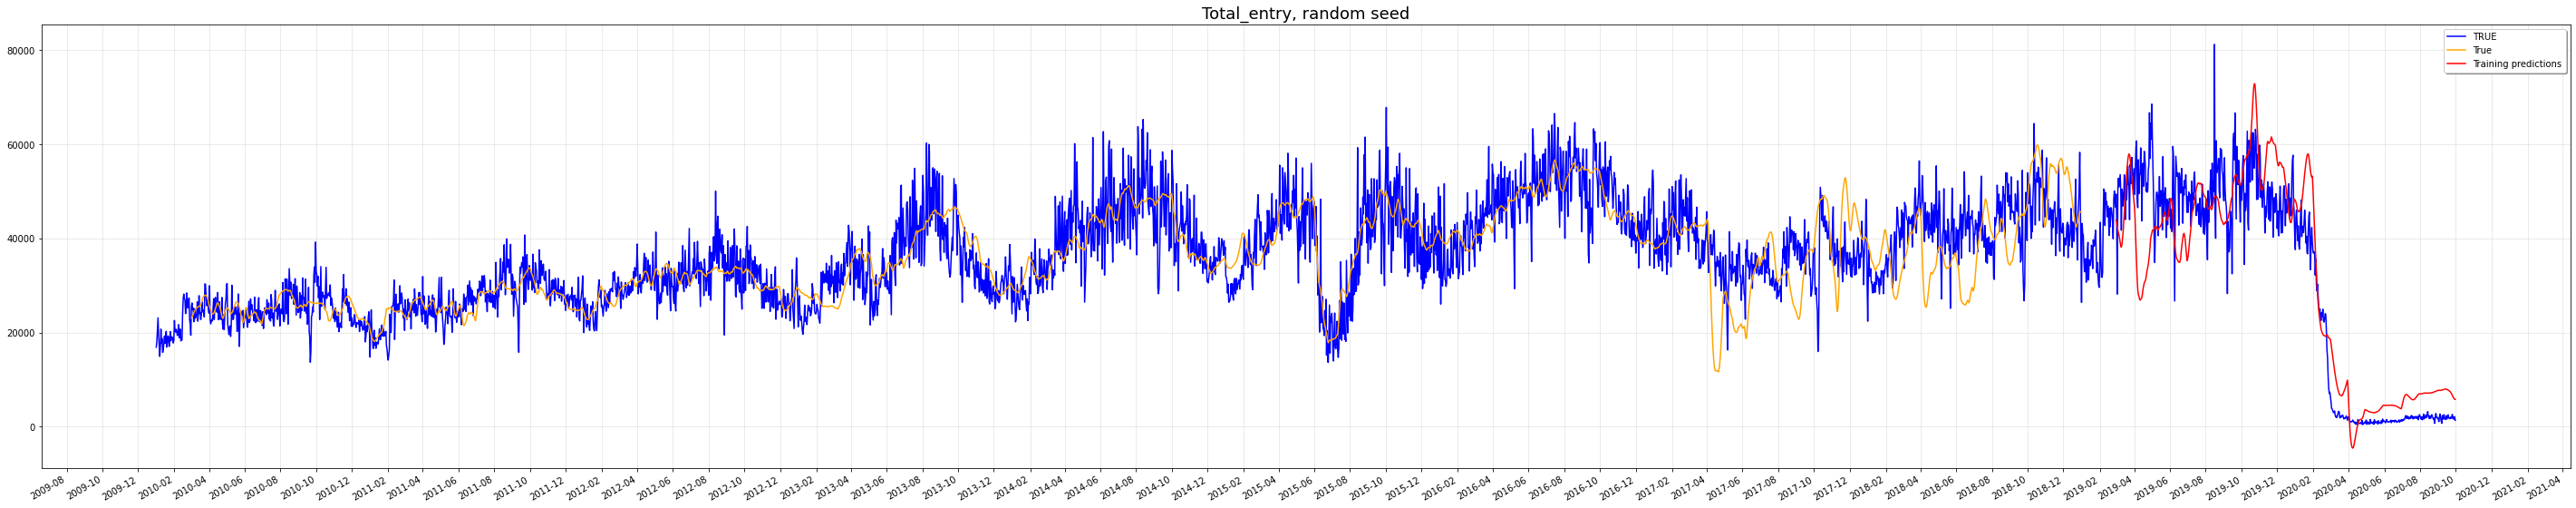

In [21]:
TRUE = pd.DataFrame(data_loader.original[:, 0:1], columns=["True"]).set_index(pd.Series(date_lists[0]))
prediction_train = wg_2.to_pandas(inv_train_predict[1:], date_lists[1], name="Train")
prediction_test = twg_2.to_pandas(inv_test_predict[1:], date_lists[2], name="Test")

plot(TRUE, prediction_train, prediction_test, show=True)

#### Evaluation
예측한 데이터와 실제 데이터의 차이, 월별 절대 오차율과 월별 절대 오차을 출력합니다.

In [22]:
printResult(date_lists[2], original, inv_test_predict, Target, features)

[2019년 3월] | 실제 방문자 수: 1548193명    | 예상 방문자 수: 1474833명       | 차이: 73360명       | 절대 오차율: 4.74%
[2019년 4월] | 실제 방문자 수: 1640434명    | 예상 방문자 수: 995771명       | 차이: 644663명       | 절대 오차율: 39.3%
[2019년 5월] | 실제 방문자 수: 1489072명    | 예상 방문자 수: 1343086명       | 차이: 145986명       | 절대 오차율: 9.8%
[2019년 6월] | 실제 방문자 수: 1481748명    | 예상 방문자 수: 1189498명       | 차이: 292250명       | 절대 오차율: 19.72%
[2019년 7월] | 실제 방문자 수: 1455545명    | 예상 방문자 수: 1460412명       | 차이: -4867명       | 절대 오차율: 0.33%
[2019년 8월] | 실제 방문자 수: 1602810명    | 예상 방문자 수: 1449874명       | 차이: 152936명       | 절대 오차율: 9.54%
[2019년 9월] | 실제 방문자 수: 1468157명    | 예상 방문자 수: 1461950명       | 차이: 6207명       | 절대 오차율: 0.42%
[2019년 10월] | 실제 방문자 수: 1658209명    | 예상 방문자 수: 1894198명       | 차이: -235989명       | 절대 오차율: 14.23%
[2019년 11월] | 실제 방문자 수: 1458691명    | 예상 방문자 수: 1709873명       | 차이: -251182명       | 절대 오차율: 17.22%
[2019년 12월] | 실제 방문자 수: 1458095명    | 예상 방문자 수: 1571158명       | 차이: -113063명       | 절대 오차율: 7.75%
[2020년 1월] | 실제 방